In [ ]:
!pip install fairlearn

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class FairLoss(nn.Module):
  """A custom loss function that combines Binary Cross-Entropy (BCE) with fairness penalty terms.

  The loss penalizes both demographic parity violations and equalized odds violations.
  Loss = BCE + λDP × DP_penalty + λEO × EO_penalty

  Args:
      lambda_dp (float): Weight for the demographic parity penalty. Defaults to 2.0.
      lambda_eo (float): Weight for the equalized odds penalty. Defaults to 2.0.
  """
  def __init__(self, lambda_dp=2.0, lambda_eo=2.0):
    super().__init__()
    self.lambda_dp = lambda_dp
    self.lambda_eo = lambda_eo
    self.bce = nn.BCEWithLogitsLoss()

  def forward(self, logits, y_true, race):
    """Calculates the total loss including BCE, demographic parity, and equalized odds penalties.

    Args:
        logits (torch.Tensor): Raw model outputs (before sigmoid).
        y_true (torch.Tensor): True binary labels.
        race (torch.Tensor): Sensitive attribute (e.g., race) with binary values (0 or 1).

    Returns:
        tuple: A tuple containing total_loss, bce_loss, dp_loss, and eo_loss.

    DP_penalty measures the squared difference in mean predicted probabilities between racial groups.
    EO_penalty averages the squared differences in True Positive Rates (TPR) and False Positive Rates (FPR)
    between racial groups for positive and negative classes separately.
    """
    logits = logits.squeeze()
    y_true = y_true.float()
    race = race.float()
    probs = torch.sigmoid(logits)

    bce_loss = self.bce(logits, y_true)

    mask_0 = (race == 0)
    mask_1 = (race == 1)

    if mask_0.sum() > 0 and mask_1.sum() > 0:
      dp_loss = (probs[mask_0].mean() - probs[mask_1].mean()) ** 2
    else:
      dp_loss = torch.tensor(0.0)

    mask_pos = (y_true == 1)
    mask_neg = (y_true == 0)

    mask_0_pos = mask_0 & mask_pos
    mask_1_pos = mask_1 & mask_pos
    mask_0_neg = mask_0 & mask_neg
    mask_1_neg = mask_1 & mask_neg

    if mask_0_pos.sum() > 0 and mask_1_pos.sum() > 0:
      tpr_loss = (probs[mask_0_pos].mean() - probs[mask_1_pos].mean()) ** 2
    else:
      tpr_loss = torch.tensor(0.0)

    if mask_0_neg.sum() > 0 and mask_1_neg.sum() > 0:
      fpr_loss = (probs[mask_0_neg].mean() - probs[mask_1_neg].mean()) ** 2
    else:
      fpr_loss = torch.tensor(0.0)

    eo_loss = (tpr_loss + fpr_loss) / 2
    total_loss = bce_loss + self.lambda_dp * dp_loss + self.lambda_eo * eo_loss

    return total_loss, bce_loss.item(), dp_loss.item(), eo_loss.item()


In [ ]:
class SimpleNN(nn.Module):
  """A simple feedforward neural network for binary classification.

  The network consists of three fully connected layers with ReLU activations and a dropout layer.
  It also stores activations of its hidden layers for analysis.

  Args:
      None
  """
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2, 32)
    self.relu1 = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.layer2 = nn.Linear(32, 16)
    self.relu2 = nn.ReLU()
    self.output = nn.Linear(16, 1)

    self.activations = {}

  def forward(self, x):
    """Performs a forward pass through the network.

    Args:
        x (torch.Tensor): Input tensor.

    Returns:
        torch.Tensor: Raw model outputs (logits).
    """
    h1 = self.relu1(self.layer1(x))
    self.activations['layer1'] = h1
    h1 = self.dropout(h1)

    h2 = self.relu2(self.layer2(h1))
    self.activations['layer2'] = h2

    out = self.output(h2)
    return out

  def get_activations(self, layer_name):
    """Retrieves the activations of a specified hidden layer.

    Args:
        layer_name (str): The name of the layer whose activations are to be retrieved ('layer1' or 'layer2').

    Returns:
        numpy.ndarray: Detached CPU numpy array of the layer's activations.
    """
    return self.activations[layer_name].detach().cpu().numpy()

In [ ]:
df = pd.read_csv("/content/lsac_data.csv")
if "ZFYGPA" in df.columns:
    df = df.rename(columns={"ZFYGPA": "zfygpa"})

needed = ["race", "gender", "lsat", "ugpa", "zfygpa"]

for c in needed:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Label: above median zfygpa
cutoff_value = np.median(df["zfygpa"])
df["admit_sim"] = (df["zfygpa"] >= cutoff_value).astype(int)

# Features (drop label, zfygpa, protected attrs)
X = df.select_dtypes(include="number").drop(
    columns=["zfygpa", "admit_sim", "race", "gender"], errors="ignore"
)
y = df["admit_sim"].astype(int)
gender = df["gender"].astype(int)
race = df["race"].astype(int)

X_train, X_test, y_train, y_test, g_train, g_test, r_train, r_test = train_test_split(
    X, y, gender, race, stratify=y, test_size=0.25, random_state=42
)

X_train = torch.FloatTensor(X_train.to_numpy())
X_test = torch.FloatTensor(X_test.to_numpy())
y_train = torch.FloatTensor(y_train.to_numpy())
y_test = torch.FloatTensor(y_test.to_numpy())
r_train = torch.LongTensor(r_train.to_numpy())
r_test = torch.LongTensor(r_test.to_numpy())

model = SimpleNN()

In [ ]:
criterion = FairLoss(lambda_dp=0.05, lambda_eo=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 256
epochs = 500

for epoch in range(epochs):
    model.train()
    indices = torch.randperm(len(X_train))

    for i in range(0, len(X_train), batch_size):
        idx = indices[i:i+batch_size]
        X_batch = X_train[idx]
        y_batch = y_train[idx]
        r_batch = r_train[idx]

        optimizer.zero_grad()
        logits = model(X_batch)
        loss, bce, dp, eo = criterion(logits, y_batch, r_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}: BCE={bce:.4f}, DP={dp:.4f}, EO={eo:.4f}, Total={loss.item():.4f}")

model.eval()
with torch.no_grad():
    logits_test = model(X_test)
    probs_test = torch.sigmoid(logits_test).squeeze().numpy()
    preds_test = (probs_test > 0.5).astype(int)

acc = accuracy_score(y_test.numpy(), preds_test)
auc = roc_auc_score(y_test.numpy(), probs_test)
dp = demographic_parity_difference(y_test.numpy(), preds_test, sensitive_features=r_test.numpy())
eo = equalized_odds_difference(y_test.numpy(), preds_test, sensitive_features=r_test.numpy())

print(f"\nNeural Network (Original Labels):")
print(f"Accuracy: {acc:.3f} | AUC: {auc:.3f}")
print(f"DP difference: {dp:.3f} | EO difference: {eo:.3f}")

Epoch 20: BCE=0.6518, DP=0.0434, EO=0.0333, Total=0.6556
Epoch 40: BCE=0.6684, DP=0.0509, EO=0.0555, Total=0.6737
Epoch 60: BCE=0.6620, DP=0.0336, EO=0.0262, Total=0.6650
Epoch 80: BCE=0.6452, DP=0.0430, EO=0.0291, Total=0.6488
Epoch 100: BCE=0.6691, DP=0.0436, EO=0.0245, Total=0.6725
Epoch 120: BCE=0.6171, DP=0.0452, EO=0.0342, Total=0.6211
Epoch 140: BCE=0.6613, DP=0.0379, EO=0.0331, Total=0.6649
Epoch 160: BCE=0.6721, DP=0.0570, EO=0.0446, Total=0.6772
Epoch 180: BCE=0.6249, DP=0.0526, EO=0.0179, Total=0.6285
Epoch 200: BCE=0.6530, DP=0.1134, EO=0.0515, Total=0.6612
Epoch 220: BCE=0.6425, DP=0.0421, EO=0.0316, Total=0.6462
Epoch 240: BCE=0.6510, DP=0.0152, EO=0.0135, Total=0.6525
Epoch 260: BCE=0.6264, DP=0.0349, EO=0.0260, Total=0.6294
Epoch 280: BCE=0.6575, DP=0.0392, EO=0.0228, Total=0.6606
Epoch 300: BCE=0.6137, DP=0.0598, EO=0.0405, Total=0.6187
Epoch 320: BCE=0.6584, DP=0.0393, EO=0.0484, Total=0.6628
Epoch 340: BCE=0.6421, DP=0.0785, EO=0.0318, Total=0.6476
Epoch 360: BCE=0.6

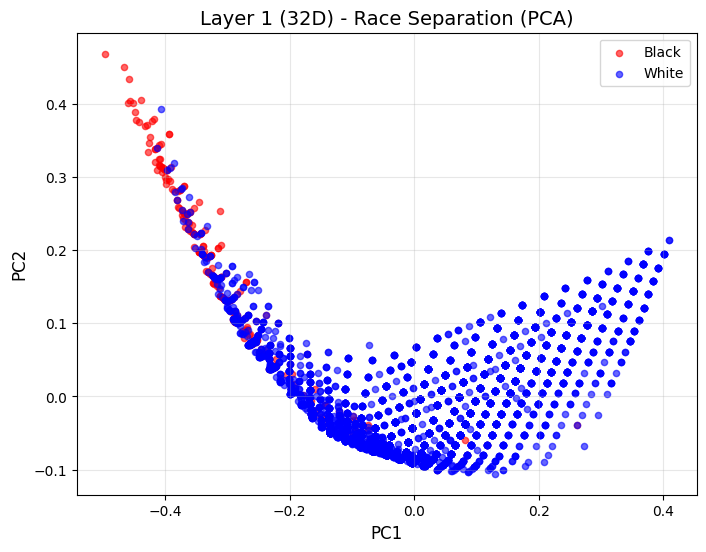

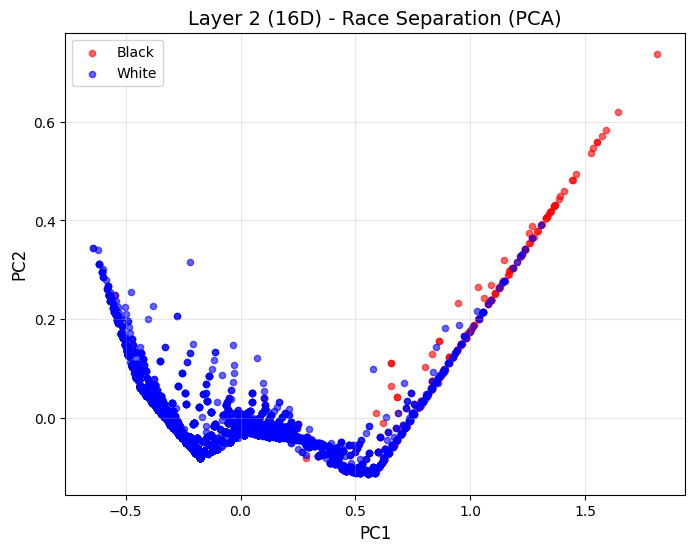

Race Separability in Hidden Layers:
  Layer 1 (32D): 0.938 (higher = more race info encoded)
  Layer 2 (16D): 0.939 (higher = more race info encoded)


In [ ]:
def plot_layer_separation(hidden, race, layer_name):
  """Plots the 2D PCA projection of hidden layer activations, colored by race.

  This function uses PCA to reduce the dimensionality of the hidden layer activations
  to 2 components and then visualizes these components, distinguishing between
  different racial groups.

  Args:
      hidden (numpy.ndarray): Hidden layer activations to be visualized.
      race (numpy.ndarray): Array of sensitive attribute (race) labels corresponding
                            to the activations.
      layer_name (str): A string representing the name of the layer for plot title.
  """
  pca = PCA(n_components=2)
  h_pca = pca.fit_transform(hidden)

  plt.figure(figsize=(8, 6))
  colors = ['red', 'blue']
  labels = ['Black', 'White']

  for r in [0, 1]:
    mask = (race == r)
    plt.scatter(h_pca[mask, 0], h_pca[mask, 1],
               c=colors[r], label=labels[r], alpha=0.6, s=20)

  plt.xlabel('PC1', fontsize=12)
  plt.ylabel('PC2', fontsize=12)
  plt.title(f'{layer_name} - Race Separation (PCA)', fontsize=14)
  plt.legend()
  plt.grid(alpha=0.3)
  plt.show()

r_test_np = r_test.numpy()
h1 = model.get_activations('layer1')
h2 = model.get_activations('layer2')

plot_layer_separation(h1, r_test_np, 'Layer 1 (32D)')
plot_layer_separation(h2, r_test_np, 'Layer 2 (16D)')

print("Race Separability in Hidden Layers:")
for layer_name, hidden in [('Layer 1 (32D)', h1), ('Layer 2 (16D)', h2)]:
  clf = LogisticRegression(max_iter=1000)
  clf.fit(hidden, r_test_np)
  race_pred = clf.predict(hidden)
  race_acc = accuracy_score(r_test_np, race_pred)
  print(f"  {layer_name}: {race_acc:.3f} (higher = more race info encoded)")